# Project Submitted by :



*   Amna Irum  21I-2802
*   Umair Ahmad 21I-2081


 





# Data Preperation 

1. Data Downloading
2. Creating the DataSet class
3. Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Downloading the data

#!wget "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unZipping the data
#!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/drive/MyDrive/VOC"

In [ ]:
# dataset class read the data for model

import collections
import os.path as osp
import numpy as np
import PIL.Image
import scipy.io
import torch
import cv2
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PascalData(data.Dataset):

    def __init__(self, root, split='train', transform=False):
        self.root = root
        self.data_t_v = split
       
        
        dataset_dir = osp.join(self.root, 'VOC/VOCdevkit/VOC2012')
        self.data_dic = collections.defaultdict(list) # creating a dictionary

        for data_t_v in ['train', 'val']:

            imgsets_file = osp.join(dataset_dir, 'ImageSets/Segmentation/%s.txt' % data_t_v)
            #reading the file names of images and labels and storing it in dictionary 
            for names in open(imgsets_file):
                names = names.strip()
                images = osp.join(dataset_dir, 'JPEGImages/%s.jpg' % names)
                labels = osp.join(dataset_dir, 'SegmentationClass/%s.png' % names)
                self.data_dic[data_t_v].append({ 'img': images, 'lbl': labels, })

    def __len__(self):
        return len(self.data_dic[self.data_t_v ])

    def __getitem__(self, index):

        # Function will return the image and label with requried dimensions 

        # class_color list consist of all the RGB colors we are going to assign to every class

        class_color = [ [0, 0, 0],[128, 0, 0], [0, 128, 0],[128, 128, 0],
                      [0, 0, 128], [128, 0, 128],[0, 128, 128],[128, 128, 128],[64, 0, 0],[192, 0, 0],
                      [64, 128, 0], [192, 128, 0],[64, 0, 128],[192, 0, 128],[64, 128, 128], [192, 128, 128],[0, 64, 0],  [128, 64, 0],
                      [0, 192, 0],[128, 192, 0],[0, 64, 128], ]
      
        data_file = self.data_dic[self.data_t_v ][index] # taking the paths of image and labels form the dictionary 
        image = cv2.imread(data_file['img'])
        image = cv2.resize(image, (160, 160))
        img   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Changing the order of Color to RGB
        img   = np.moveaxis(img, -1, 0) # 3xhxw, changing the dimension to NoofChannels X Height X Weight

        lbl = cv2.imread(data_file['lbl'])
        lbl = cv2.resize(lbl, (160, 160))
        lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2RGB)
       
        height, width = lbl.shape[:2]
        c_lbl = np.zeros((height, width, len(class_color)), dtype=np.float32)

        for label_index, label in enumerate(class_color):
            c_lbl[:, :, label_index] = np.all(lbl == label, axis=-1).astype(float)
            
        c_lbl = np.array(c_lbl, dtype=np.float32)
        c_lbl=np.moveaxis(c_lbl, -1, 0) #  21xhxw, changing the dimension to NoofClass X Height X Weight
        i_data = {'In':img, 'Ta':c_lbl}  # returning the dic of image and label
        return i_data


In [ ]:
#Loading data

P_data     = PascalData('/content/drive/MyDrive/' , split='train', transform=False)
dataloader = DataLoader(P_data, batch_size=30, shuffle=True, num_workers=2) # batch siz according to FCN paper to take images randomly 


# FCN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG
import pdb
import numpy as np 
import time
import numpy as np

# Code Reference  


class FCNs(nn.Module): #The module torch. nn contains different classess that help you build neural network models.

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)


    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16) Skip Connection...
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)



class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)






# VGG 8 cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
# Reference : https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(Layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = { 'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}

cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

def Layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


# Training

In [ ]:
    
    vgg_model = VGGNet(requires_grad=True)
    fcn_model = FCNs(pretrained_net=vgg_model, n_class=21)
    fcn_model = fcn_model.cuda()

    # CrossEntropyLoss
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) #
   
    saving_index =0
    for epo in range(100):
        saving_index +=1
        index = 0
        epo_loss = 0
        start = time.time()
        for d in dataloader:
            index += 1
            start = time.time()
            input = d['In']
            y = d['Ta']
            input = torch.autograd.Variable(input)
            y = torch.autograd.Variable(y)

            input = input.cuda()
            y = y.cuda()

            optimizer.zero_grad()
            output = fcn_model(input)
              
            SS=nn.Softmax(dim=2) 
            output=SS(output) # softmax 

            loss = criterion(output, y)
            loss.backward()
            iter_loss = loss.data.item()
            epo_loss += iter_loss
            optimizer.step() # update 

      
            if np.mod(index, 20) ==1:
                print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
            
        print('epoch loss = %f'%(epo_loss/len(dataloader)))
        
        if np.mod(saving_index, 5)==1:
            torch.save(fcn_model, '/content/drive/MyDrive/FCN checkpoints/fcn_model_{}.pt'.format(epo))
            print('/content/drive/MyDrive/FCN checkpoints/fcn_model_{}.pt'.format(epo))

# Inference

In [ ]:
#Loading data

Val_data = PascalData('/content/drive/MyDrive/' , split='val', transform=False)
Val_dataloader = DataLoader(Val_data, batch_size=30, shuffle=True, num_workers=2)

(160, 160, 3)


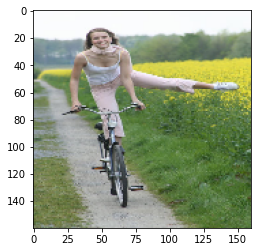

torch.Size([2, 21, 160, 160])


In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

for d in Val_dataloader:
  img = d['In']
  lbl = d['Ta']

  input=np.moveaxis(img[0,:,:,:].detach().numpy(), 0,-1)
  print(input.shape)

  plt.imshow(input)
  plt.show()

  model = torch.load('/content/drive/MyDrive/FCN checkpoints/fcn_model_95.pt',map_location=torch.device('cpu'))
  model = model.cpu()
  #y is the output, of shape N*21*160*160
  x = Variable(torch.FloatTensor(img.detach().numpy()))
  pred = model(x)
  
  print(pred.shape)
  break

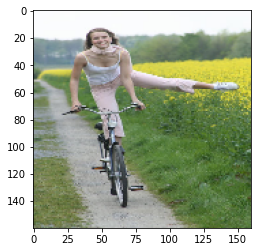

(160, 160)
Predicted Image


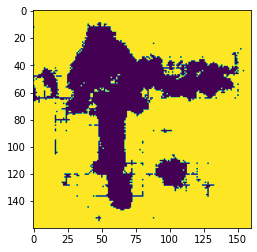

Ground Truth Image


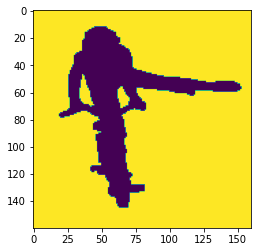

class= background
i= 0
(160, 160)
Predicted Image


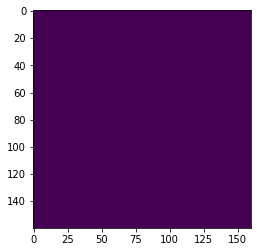

Ground Truth Image


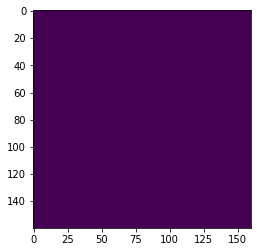

class= aeroplane
i= 1
(160, 160)
Predicted Image


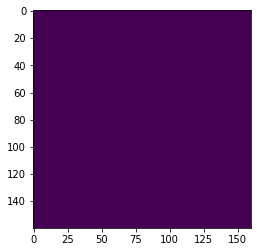

Ground Truth Image


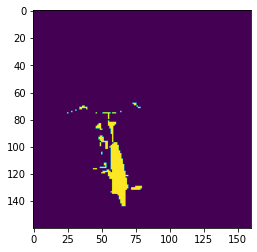

class= bicycle
i= 2
(160, 160)
Predicted Image


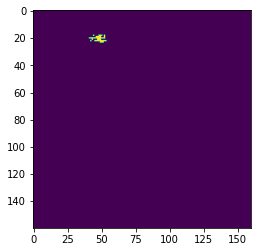

Ground Truth Image


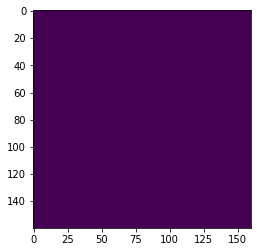

class= bird
i= 3
(160, 160)
Predicted Image


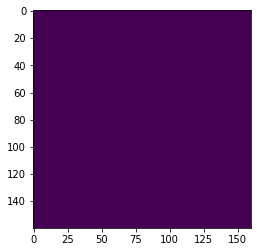

Ground Truth Image


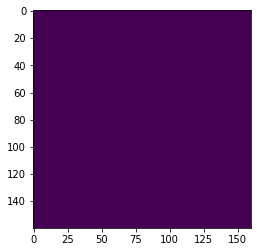

class= boat
i= 4
(160, 160)
Predicted Image


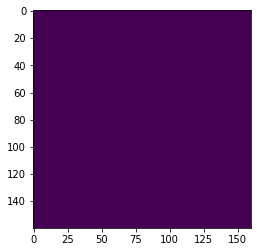

Ground Truth Image


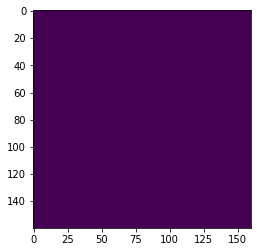

class= bottle
i= 5
(160, 160)
Predicted Image


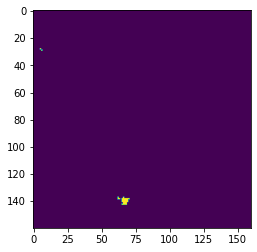

Ground Truth Image


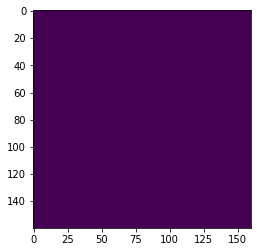

class= bus
i= 6
(160, 160)
Predicted Image


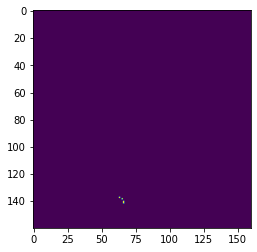

Ground Truth Image


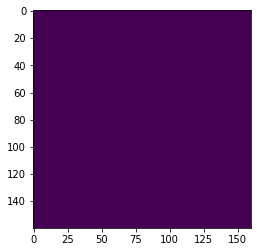

class= car
i= 7
(160, 160)
Predicted Image


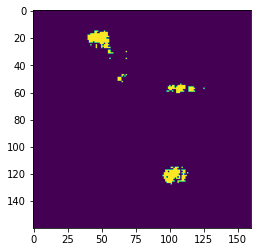

Ground Truth Image


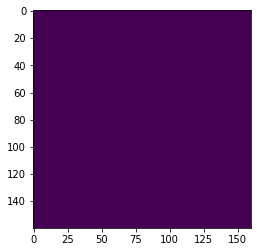

class= cat
i= 8
(160, 160)
Predicted Image


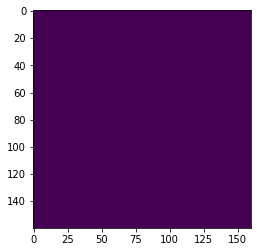

Ground Truth Image


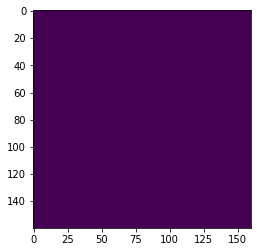

class= chair
i= 9
(160, 160)
Predicted Image


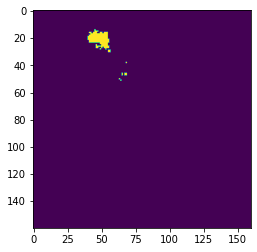

Ground Truth Image


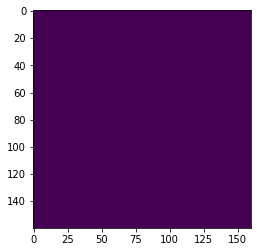

class= cow
i= 10
(160, 160)
Predicted Image


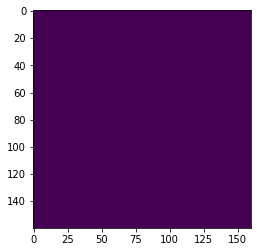

Ground Truth Image


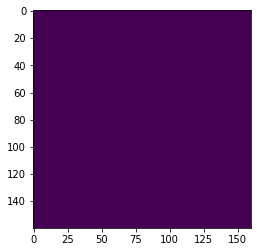

class= diningtable
i= 11
(160, 160)
Predicted Image


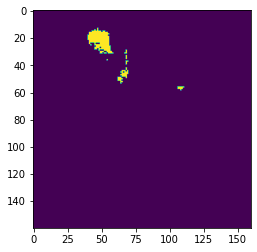

Ground Truth Image


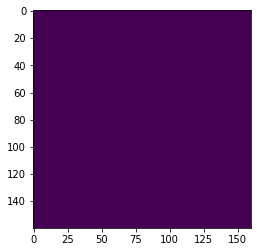

class= dog
i= 12
(160, 160)
Predicted Image


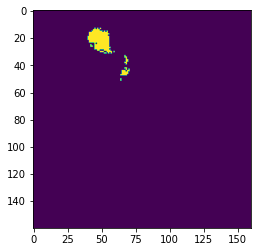

Ground Truth Image


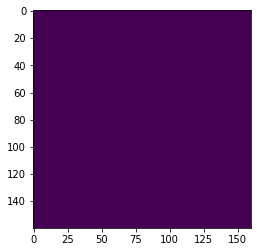

class= horse
i= 13
(160, 160)
Predicted Image


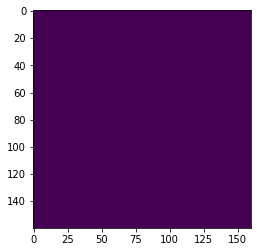

Ground Truth Image


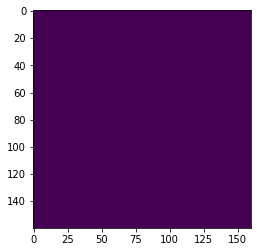

class= motorbike
i= 14
(160, 160)
Predicted Image


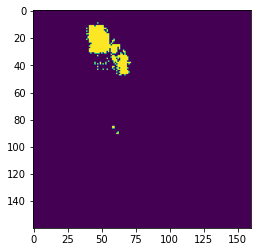

Ground Truth Image


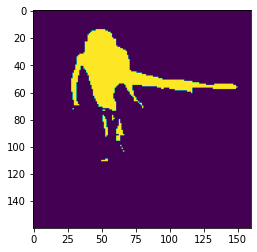

class= person
i= 15
(160, 160)
Predicted Image


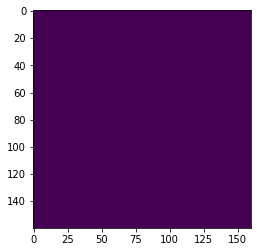

Ground Truth Image


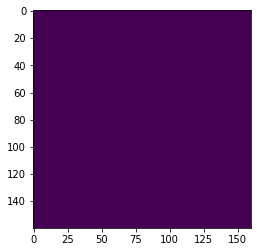

class= potted plant
i= 16
(160, 160)
Predicted Image


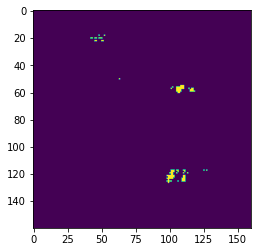

Ground Truth Image


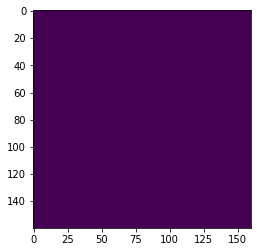

class= sheep
i= 17
(160, 160)
Predicted Image


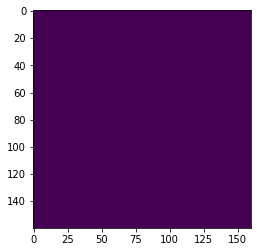

Ground Truth Image


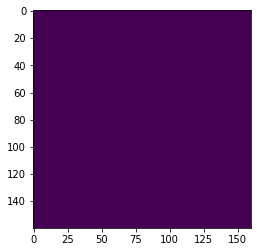

class= sofa
i= 18
(160, 160)
Predicted Image


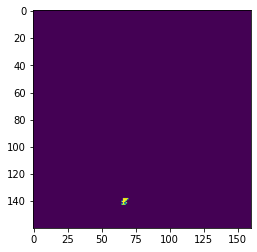

Ground Truth Image


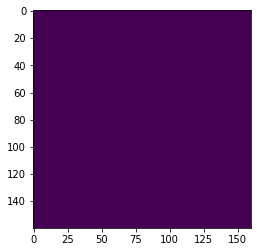

class= train
i= 19
(160, 160)
Predicted Image


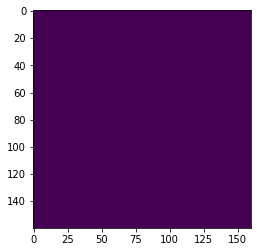

Ground Truth Image


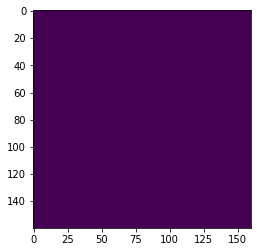

class= tv/monitor
i= 20


In [ ]:
#Data Visualization
VOC_CLASSES = [
                      "background",
                      "aeroplane",
                      "bicycle",
                      "bird",
                      "boat",
                      "bottle",
                      "bus",
                      "car",
                      "cat",
                      "chair",
                      "cow",
                      "diningtable",
                      "dog",
                      "horse",
                      "motorbike",
                      "person",
                      "potted plant",
                      "sheep",
                      "sofa",
                      "train",
                      "tv/monitor",
                  ]

i=0
##GT=np.moveaxis(lbl.detach().numpy(), 1,-1)
#image=np.moveaxis(pred.detach().numpy(), 1, -1)
plt.imshow(input)
plt.show()
for pre,gt in zip(pred,lbl):
  for Pre,GT in zip(pre,gt):
    print(Pre.detach().numpy().shape)
    
    Pred = np.where(Pre > 5, 1, 0)
    print("Predicted Image")
    plt.imshow(Pred)
    plt.show()
    print("Ground Truth Image")
    plt.imshow(GT)
    plt.show()
    print("class=",VOC_CLASSES[i])
    print("i=",i)
    i=i+1
  break
    

In [ ]:
# Accuracy and IOU calcultion 
i=0
ClassIOU=np.zeros(21)#Vector that Contain IOU per class
ClassWeight=np.zeros(21)#Vector that Contain Number of pixel per class Predicted U Ground true (Union for this class)
for pre,gt in zip(pred,lbl):
  for Pre,GT in zip(pre,gt):
    Pre = np.where(Pre.detach().numpy() > 5, 1, 0)
    Intersection=np.float32(np.sum((Pre==GT.detach().numpy())*(GT.detach().numpy()==0)))# Calculate intersection
    Union=np.sum(GT.detach().numpy()==0)+np.sum(Pre==0)-Intersection # Calculate Union
    if Union>0:
      ClassIOU[i]=Intersection/Union# Calculate intesection over union
      ClassWeight[i]=Union
    print(VOC_CLASSES[i]+" class IOU) "+str(ClassIOU[i]))
    print("Image Predicition Accuracy)" + str(np.float32(np.sum(Pre== GT.detach().numpy())) / GT.detach().numpy().size))
    print(i)
    i=i+1
  break
print("Mean Classes IOU) "+str(np.mean(ClassIOU)))

background class IOU) 0.6161425880307202
Image Predicition Accuracy)0.8965234375
0
aeroplane class IOU) 1.0
Image Predicition Accuracy)1.0
1
bicycle class IOU) 0.9778515625
Image Predicition Accuracy)0.9778515625
2
bird class IOU) 0.9984765625
Image Predicition Accuracy)0.9984765625
3
boat class IOU) 1.0
Image Predicition Accuracy)1.0
4
bottle class IOU) 1.0
Image Predicition Accuracy)1.0
5
bus class IOU) 0.9988671875
Image Predicition Accuracy)0.9988671875
6
car class IOU) 0.99984375
Image Predicition Accuracy)0.99984375
7
cat class IOU) 0.9854296875
Image Predicition Accuracy)0.9854296875
8
chair class IOU) 1.0
Image Predicition Accuracy)1.0
9
cow class IOU) 0.9937109375
Image Predicition Accuracy)0.9937109375
10
diningtable class IOU) 1.0
Image Predicition Accuracy)1.0
11
dog class IOU) 0.989453125
Image Predicition Accuracy)0.989453125
12
horse class IOU) 0.9901171875
Image Predicition Accuracy)0.9901171875
13
motorbike class IOU) 1.0
Image Predicition Accuracy)1.0
14
person class 